# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

In [96]:
# 1. looking for apartments on Craigslist
url = 'https://richmond.craigslist.org/search/powhatan-va/apa?lat=37.5708&lon=-77.9797&search_distance=60#search=1~gallery~0~0'
raw = requests.get(url,headers=header)

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

In [98]:
# 1. extract data
bso = soup(raw.content,'html.parser')
listings = bso.find_all(class_="cl-static-search-result") # all search results

# 2. search within each listing for apartments with 'Richmond', 'Charlottesville', or 'Midlothian'
cities = ["Richmond", "Charlottesville", "Midlothian", "Fredericksburg", "Petersburg", "Ashland"]

data = [] # save listings
for k in range( len(listings) ): # use .find() to search within each listing
    title = listings[k].find('div',class_='title').get_text().lower() # use get_text() to get info we want
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    loc_element = listings[k].find('div',class_='location')
    if loc_element:
        location = loc_element.get_text()
        # check for cities mentioned
        words = location.split() # split the location into words
        hits = [word for word in words if word in cities] # check each word
        if len(hits) == 0:
          city = 'missing'
        else:
          city = hits[0]
        # add to data object
        data.append({'title':title,'price':price,'link':link,'city':city})
    else:
        location = 'missing'

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(83, 6)


,title,price,year,link,brand,age
0,a sweet sedan avalon xle plus,26000,NaN,https://charlottesville.craigslist.org/cto/d/c...,missing,NaN
1,2007 honda element ex,8500,2007.0,https://charlottesville.craigslist.org/cto/d/h...,honda,18.0
2,2009 honda odyssey ex-l,4000,2009.0,https://charlottesville.craigslist.org/cto/d/c...,honda,16.0
3,2004 ford f250,9000,2004.0,https://charlottesville.craigslist.org/cto/d/c...,ford,21.0
4,2005 dodge ram 2500 diesal,13000,2005.0,https://charlottesville.craigslist.org/cto/d/k...,dodge,20.0


With the data in and wrangled, we can now do EDA:

count       83.000000
mean      9153.493976
std       8521.712908
min       1200.000000
25%       3500.000000
50%       6500.000000
75%      11000.000000
max      55000.000000
Name: price, dtype: float64


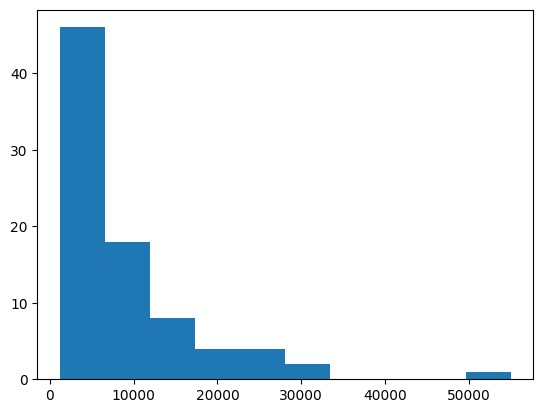

count    70.000000
mean     23.442857
std      14.461980
min       5.000000
25%      13.000000
50%      19.000000
75%      30.000000
max      68.000000
Name: age, dtype: float64


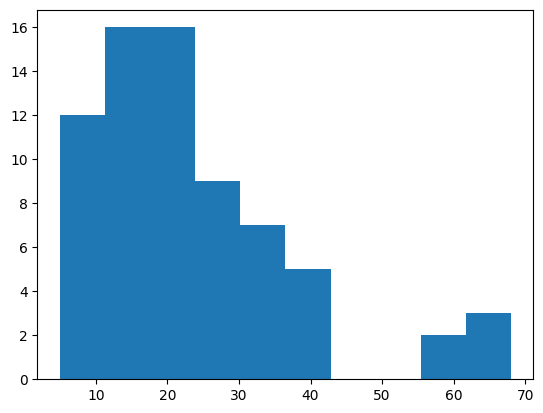

In [ ]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
bmw          2.0  11225.000000   8874.190104   4950.0   8087.5  11225.0   
chevrolet    2.0   9625.000000   7247.844507   4500.0   7062.5   9625.0   
chevy        6.0   7866.666667   5086.714722   2500.0   3675.0   7700.0   
dodge        3.0  15300.000000   5802.585631  11000.0  12000.0  13000.0   
ford        10.0  11020.000000  15827.247953   1300.0   3275.0   6500.0   
gmc          1.0   7100.000000           NaN   7100.0   7100.0   7100.0   
honda        7.0   4914.285714   2568.675775   1800.0   3000.0   4700.0   
infiniti     1.0   5300.000000           NaN   5300.0   5300.0   5300.0   
jeep         3.0   5233.333333   4128.357220   2800.0   2850.0   2900.0   
lexus        1.0  10900.000000           NaN  10900.0  10900.0  10900.0   
mazda        1.0  23900.000000           NaN  23900.0  23900.0  23900.0   
missing     32.0   8701.562500   7697.595816   1200.0   3437.5   6100.0   
tesla        1.0  24999.000000           NaN  24999.0  24999.0  24999.0   
toyota      11.0   8440.090909   7701.464049   3000.0   3546.0   4500.0   
volkswagen   1.0  13950.000000           NaN  13950.0  13950.0  13950.0   
volvo        1.0   7200.000000           NaN   7200.0   7200.0   7200.0   

                              
                75%      max  
brand                         
bmw         14362.5  17500.0  
chevrolet   12187.5  14750.0  
chevy       10900.0  15000.0  
dodge       17450.0  21900.0  
ford         9750.0  55000.0  
gmc          7100.0   7100.0  
honda        6700.0   8500.0  
infiniti     5300.0   5300.0  
jeep         6450.0  10000.0  
lexus       10900.0  10900.0  
mazda       23900.0  23900.0  
missing      9000.0  29000.0  
tesla       24999.0  24999.0  
toyota      11249.5  28500.0  
volkswagen  13950.0  13950.0  
volvo        7200.0   7200.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
bmw          2.0  15.000000   8.485281   9.0  12.00  15.0  18.00  21.0
chevrolet    2.0  36.000000   0.000000  36.0  36.00  36.0  36.00  36.0
chevy        3.0  33.000000   4.358899  30.0  30.50  31.0  34.50  38.0
dodge        2.0  23.500000   4.949747  20.0  21.75  23.5  25.25  27.0
ford        10.0  19.800000  10.850499   8.0  10.50  18.0  27.25  38.0
gmc          1.0  27.000000        NaN  27.0  27.00  27.0  27.00  27.0
honda        7.0  18.571429   6.948792  12.0  14.50  18.0  19.00  33.0
infiniti     1.0  16.000000        NaN  16.0  16.00  16.0  16.00  16.0
jeep         2.0  21.000000  12.727922  12.0  16.50  21.0  25.50  30.0
lexus        1.0  13.000000        NaN  13.0  13.00  13.0  13.00  13.0
mazda        1.0   6.000000        NaN   6.0   6.00   6.0   6.00   6.0
missing     24.0  28.958333  19.974939   5.0  14.75  20.5  41.00  68.0
tesla        1.0   9.000000        NaN   9.0   9.00   9.0   9.00   9.0
toyota      11.0  19.454545   8.358991   9.0  15.00  18.0  20.50  41.0
volkswagen   1.0  10.000000        NaN  10.0  10.00  10.0  10.00  10.0
volvo        1.0  33.000000        NaN  33.0  33.00  33.0  33.00  33.0

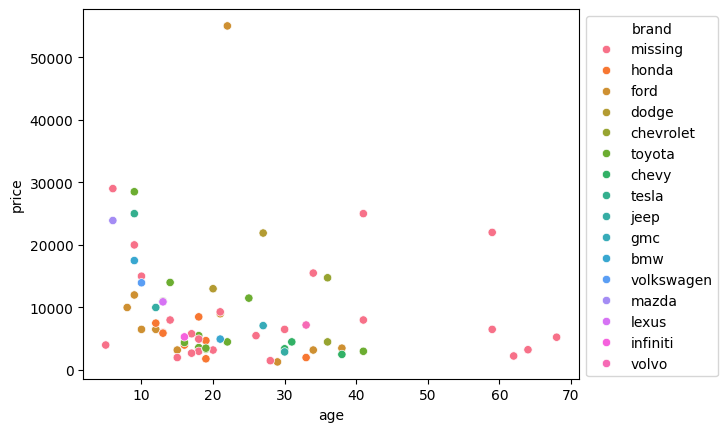

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.638134 -0.161537
log_age    -0.161537  0.352880
           log_price   log_age
log_price   1.000000 -0.338341
log_age    -0.338341  1.000000


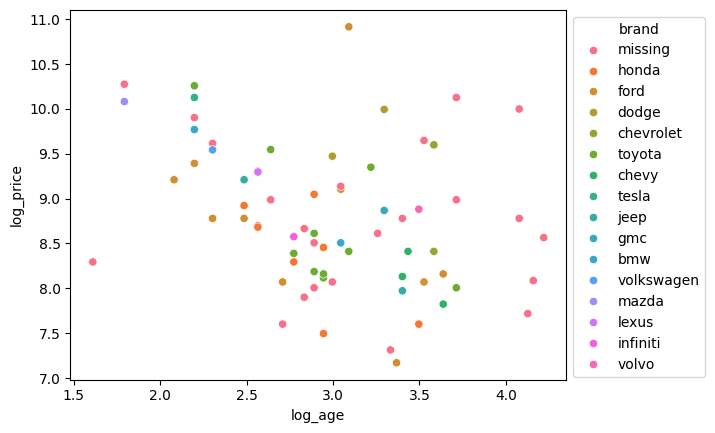

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

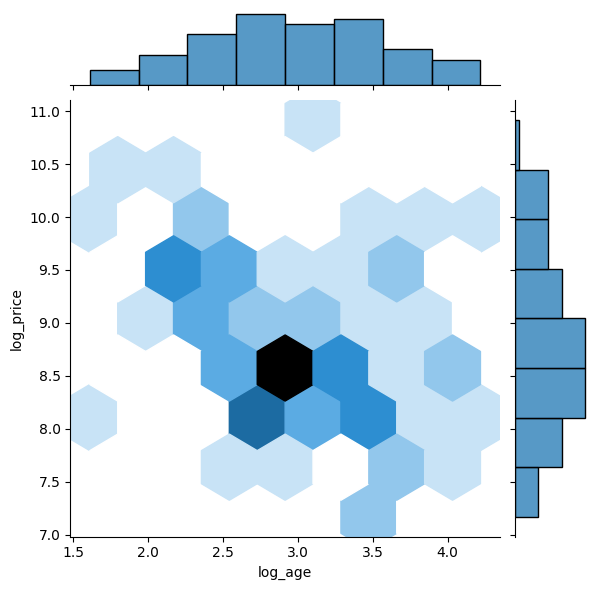

In [ ]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')

*Now let's use my data from Craiglist looking at apartments in central Virginia area for lab 02.*

In [99]:
# 1. Let's look at the saved data
df = pd.DataFrame.from_dict(data)
print(df.shape)
df.head()

(320, 4)


,title,price,link,city
0,"gorgeous light filled 953 sq ft, 2 bed, 2 bath...","$1,638",https://fredericksburg.craigslist.org/apa/d/fr...,Fredericksburg
1,"online rent pay, 24 hour emergency service, pa...","$1,729",https://fredericksburg.craigslist.org/apa/d/fr...,missing
2,every day's a journey: begin and end yours in ...,"$1,537",https://richmond.craigslist.org/apa/d/midlothi...,Midlothian
3,"online maintenance portal, club house, 2 bd","$1,050",https://richmond.craigslist.org/apa/d/henrico-...,missing
4,"1 bedroom, laundry facility, gazebo with 2 gas...","$1,649",https://richmond.craigslist.org/apa/d/ashland-...,missing


In [100]:
# 2. Convert price variable to numeric
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_apt.csv') # Save data in case of a disaster
df.head()

(320, 4)


,title,price,link,city
0,"gorgeous light filled 953 sq ft, 2 bed, 2 bath...",1638,https://fredericksburg.craigslist.org/apa/d/fr...,Fredericksburg
1,"online rent pay, 24 hour emergency service, pa...",1729,https://fredericksburg.craigslist.org/apa/d/fr...,missing
2,every day's a journey: begin and end yours in ...,1537,https://richmond.craigslist.org/apa/d/midlothi...,Midlothian
3,"online maintenance portal, club house, 2 bd",1050,https://richmond.craigslist.org/apa/d/henrico-...,missing
4,"1 bedroom, laundry facility, gazebo with 2 gas...",1649,https://richmond.craigslist.org/apa/d/ashland-...,missing


count     320.000000
mean     1514.728125
std       324.357109
min         0.000000
25%      1435.000000
50%      1537.000000
75%      1729.000000
max      2500.000000
Name: price, dtype: float64


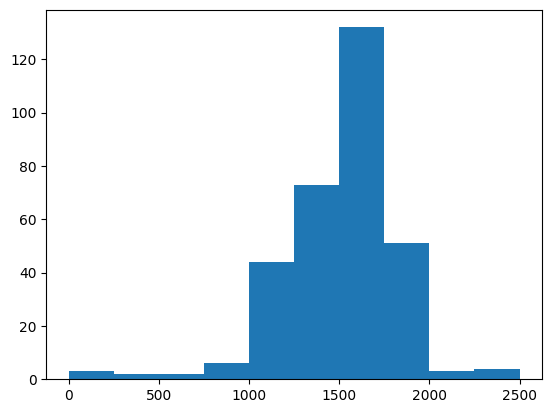

In [101]:
# 3. EDA for price
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

In [102]:
# 4. Describe table- price by city
df.loc[:,['price','city']].groupby('city').describe()

price                                                   \
                 count         mean         std     min     25%     50%   
city                                                                      
Charlottesville    1.0   706.000000         NaN   706.0   706.0   706.0   
Fredericksburg    51.0  1560.215686  165.910255   795.0  1513.0  1531.0   
Midlothian        20.0  1526.850000   45.392180  1334.0  1537.0  1537.0   
Petersburg         1.0   900.000000         NaN   900.0   900.0   900.0   
Richmond          67.0  1508.104478  436.344288     0.0  1365.0  1497.0   
missing          180.0  1510.866667  320.906248     1.0  1335.5  1513.0   

                                 
                    75%     max  
city                             
Charlottesville   706.0   706.0  
Fredericksburg   1638.0  1949.0  
Midlothian       1537.0  1537.0  
Petersburg        900.0   900.0  
Richmond         1810.5  2395.0  
missing          1729.0  2500.0

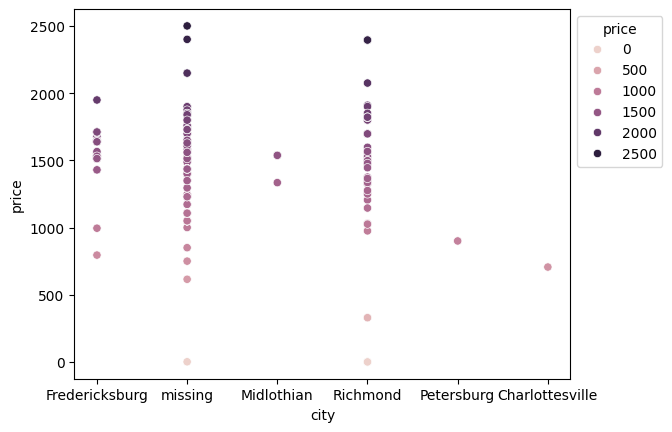

In [103]:
# 5. Scatterplot
PxC = sns.scatterplot(data=df, x='city', y='price', hue='price')
sns.move_legend(PxC, "upper left", bbox_to_anchor=(1, 1))

*Most of the listed apartments are located in Richmond, followed by Fredericksburg, Midlothian, and a few properties in Charlotesville and Petersburg. From our table, apartments in Richmond average around 1508.10 dollars in rent, 1560.22 dollars for Fredericksburg, and 1526.85 dollars for Midlothian. From our scatterplot, it seems that Richmond is the location with the largest range of prices, with both the most expensive and least expensive prices from the website- perhaps it has a greater number of available apartments than any other listed city. Also, the majority of apartments on Craiglist were located in cities that I didn't search for, so there are probably some more expensive or less expensive locations available.*

## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

In [ ]:
import time # Time delays
import random # Random numbers

links = df['link']
data = []
for link in links: # about 3 minutes
    time.sleep(random.randint(1, 3)) # Random delays
    raw = requests.get(link,headers=header) # Get page
    bsObj = soup(raw.content,'html.parser') # Parse the html
    #
    try:
        year_post = bsObj.find(class_='attr important').find(class_ = 'valu year').get_text()
    except:
        year_post = np.nan
    #
    try:
        condition = bsObj.find(class_='attr condition').find(href=True).get_text()
    except:
        condition = 'missing'
    #
    try:
        cylinders = bsObj.find(class_='attr auto_cylinders').find(class_ = 'valu').get_text()
        cylinders = cylinders.replace('\n','')
    except:
        cylinders = 'missing'
    #
    try:
        drivetrain = bsObj.find(class_='attr auto_drivetrain').find(href=True).get_text()
    except:
        drivetrain = 'missing'
    #
    try:
        fuel = bsObj.find(class_='attr auto_fuel_type').find(href = True).get_text()
    except:
        fuel = 'missing'
    #
    try:
        miles = bsObj.find(class_='attr auto_miles').find(class_ = 'valu').get_text()
    except:
        miles = np.nan
    #
    try:
        color = bsObj.find(class_='attr auto_paint').find(href=True).get_text()
    except:
        color='missing'
    #
    try:
        title = bsObj.find(class_='attr auto_title_status').find(href=True).get_text()
    except:
        title='missing'
    #
    try:
        transmission = bsObj.find(class_='attr auto_transmission').find(href=True).get_text()
    except:
        transmission = 'missing'
    #
    try:
        bodytype = bsObj.find(class_='attr auto_bodytype').find(href=True).get_text()
    except:
        bodytype = 'missing'
    #
    text = bsObj.find(id='postingbody').get_text()
    text = text.replace('\n','')
    text = text.replace('QR Code Link to This Post','')
    record = {'title':title,
              'year_post':year_post,
              'condition':condition,
              'cylinders':cylinders,
              'drivetrain':drivetrain,
              'fuel':fuel,
              'miles':miles,
              'color':color,
              'title':'title',
              'transmission':transmission,
              'bodytype':bodytype,
              'text':text,}
    data.append(record)

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

In [ ]:
new_df = pd.DataFrame.from_dict(data)
new_df.head()

df = pd.concat([df,new_df],axis=1) # combine data frames
df.head()

df['miles'] = df['miles'].str.replace(',','')
df['miles'] = pd.to_numeric(df['miles'],errors='coerce')

df['year_post'] = df['year_post'].str.replace(',','')
df['year_post'] = pd.to_numeric(df['year_post'],errors='coerce')
df.to_csv('craiglist_cville_cars_long.csv')